In [6]:
import pandas as p

df = p.read_csv("Data/Reviews.csv")
df.head()

Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...
3   4  ...  If you are looking for the secret ingredient i...
4   5  ...  Great taffy at a great price.  There was a wid...

[5 rows x 10 columns]

In [7]:
print(df.isnull().sum())

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [9]:
df["helpfulness_rating"] = df["HelpfulnessNumerator"]/ (df["HelpfulnessDenominator"])

df.head()
df.describe()

Id  HelpfulnessNumerator  ...          Time  helpfulness_rating
count  568454.000000         568454.000000  ...  5.684540e+05       298402.000000
mean   284227.500000              1.743817  ...  1.296257e+09            0.776975
std    164098.679298              7.636513  ...  4.804331e+07            0.346321
min         1.000000              0.000000  ...  9.393408e+08            0.000000
25%    142114.250000              0.000000  ...  1.271290e+09            0.600000
50%    284227.500000              0.000000  ...  1.311120e+09            1.000000
75%    426340.750000              2.000000  ...  1.332720e+09            1.000000
max    568454.000000            866.000000  ...  1.351210e+09            3.000000

[8 rows x 6 columns]

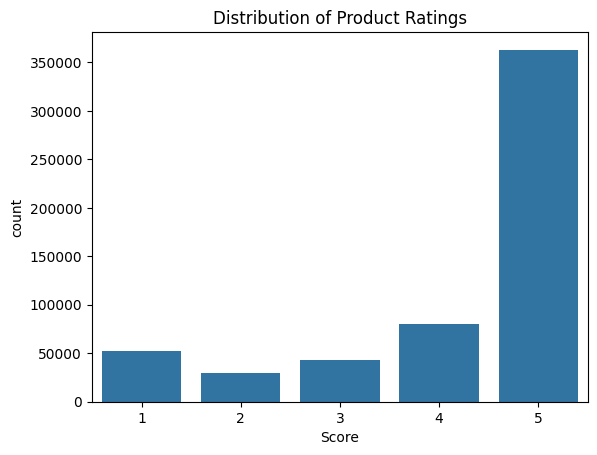

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=df, x='Score')
plt.title('Distribution of Product Ratings')
plt.show()

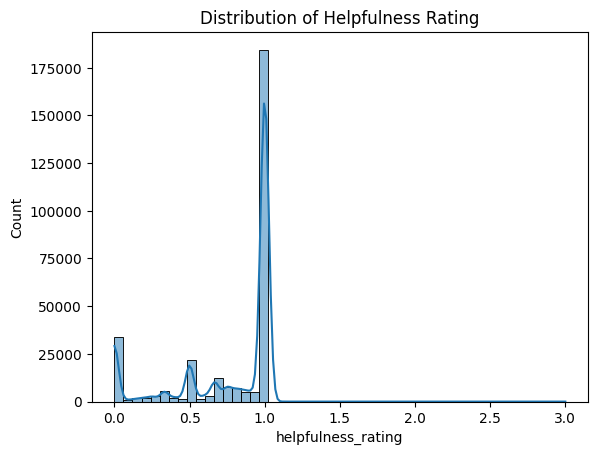

In [11]:
sns.histplot(data=df, x='helpfulness_rating', bins=50, kde=True)
plt.title('Distribution of Helpfulness Rating')
plt.show()

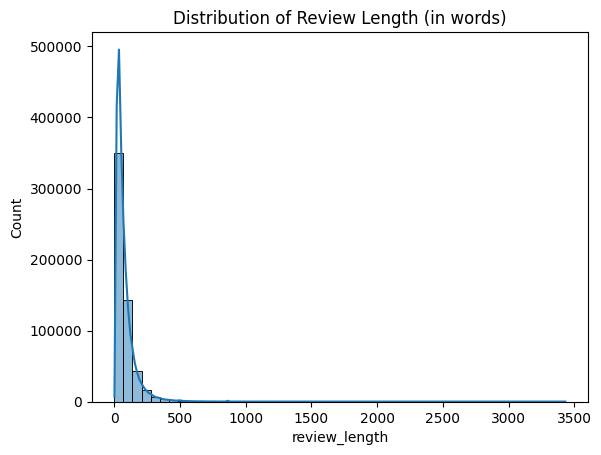

In [12]:
df['review_length'] = df['Text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Length (in words)')
plt.show()

In [13]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CAR5859\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CAR5859\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CAR5859\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_basic(text):
   
    
    text = text.lower() 
    text = re.sub('[^a-zA-Z]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    
    return ' '.join(tokens)

def preprocess_text_full(text):
   
    
    text = str(text).lower() 
    text = re.sub('[^a-zA-Z]', ' ', text)
    #extras compared to basic
    text = re.sub(r"\d", "0", text)
    text = re.sub(r"[^\w\s]", "", text)
    
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    
    return ' '.join(tokens)

#### merging bigrams (type of collocation) for the full text preprocessing function

In [15]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

# Suppose you have a list of tokenized documents, e.g.:
# documents = [
#     ["i", "love", "new", "york", "city"],
#     ["this", "new", "york", "cheesecake", "is", "amazing"],
#     ...
# ]

def build_bigram_set(documents, freq_filter=5, top_n=20):
    """
    documents: list of raw text strings (unprocessed)
    freq_filter: minimum times a bigram must appear
    top_n: number of bigrams to return based on likelihood ratio
    """
    
    # 1. Preprocess each doc, then collect all tokens in a single list
    all_tokens = []
    for text in documents:
        processed = preprocess_text_full(text)   # "i love new york city"
        tokens = processed.split()          # ["i", "love", "new", "york", "city"]
        all_tokens.extend(tokens)
    
    # 2. Use NLTK to find bigrams in the entire corpus
    finder = BigramCollocationFinder.from_words(all_tokens)
    finder.apply_freq_filter(freq_filter)
    
    finder = BigramCollocationFinder.from_words(
    nltk.corpus.genesis.words('english-web.txt'))
    # return the 10 n-grams with the highest PMI
    bigrams = finder.nbest(BigramAssocMeasures.likelihood_ratio, top_n) 
    # 4. Return a set of bigram tuples, e.g. {("new", "york"), ("olive", "oil"), ...}
    return set(bigrams)


In [16]:
nltk.download('genesis')
def merge_collocations(tokens, bigram_set):
    """
    Merges adjacent tokens into a single token (e.g., "new_york")
    if (token[i], token[i+1]) is in bigram_set.
    """
    merged_tokens = []
    i = 0
    while i < len(tokens) - 1:
        pair = (tokens[i], tokens[i+1])
        if pair in bigram_set:
            merged_tokens.append(tokens[i] + "_" + tokens[i+1])
            i += 2  # Skip the next token (it's merged)
        else:
            merged_tokens.append(tokens[i])
            i += 1
    # If there's an odd token left at the end
    if i == len(tokens) - 1:
        merged_tokens.append(tokens[i])
    return merged_tokens

[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\CAR5859\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!


In [17]:
def preprocess_and_merge_collocations(text, bigram_set):
    """
    1) Preprocess the text using preprocess_text
    2) Split into tokens
    3) Merge any known bigrams
    4) Return the processed string
    """
    # Preprocess to get a cleaned string
    cleaned_str = preprocess_text_full(text)
    # Tokenize that cleaned string
    tokens = cleaned_str.split()
    # Merge any collocations in these tokens
    merged_tokens = merge_collocations(tokens, bigram_set)
    # Return as a string
    return ' '.join(merged_tokens)

In [18]:
df_sample = df.sample(n=10000, random_state=42)

In [19]:
df_sample["Score"].value_counts()

Score
5    6397
4    1455
1     891
3     750
2     507
Name: count, dtype: int64

In [20]:
nltk.download('punkt_tab')
# Suppose you have a small corpus of raw documents
# For example, take a random sample of 50k reviews out of 500k

reviews = df_sample["Text"].to_list()
reviews_collocated = ["vroom"]*len(reviews)
# 1. Build the bigram set based on the entire corpus
my_bigram_set = build_bigram_set(reviews, freq_filter=2, top_n=100)

print("Bigram Set:", my_bigram_set)
# e.g., {('new', 'york'), ('olive', 'oil'), ...}

# 2. Preprocess and merge collocations for each doc
for i in range(len(reviews)):
    print("  original: " + reviews[i])
    reviews_collocated[i] = (preprocess_and_merge_collocations(reviews[i], my_bigram_set))
    print("collocated: " + reviews_collocated[i])


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\CAR5859\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Bigram Set: {('to', 'them'), ('?"', 'He'), ('rose', 'up'), ('The', 'sons'), ('.', 'When'), ('that', 'he'), ('went', 'out'), ('after', 'their'), ('These', 'are'), ('him', ','), ('I', 'am'), ('out', 'of'), ('the', 'ground'), ('have', 'done'), ('God', 'has'), ('said', ','), (',', 'saying'), ('didn', "'"), ('and', 'they'), ('seven', 'years'), ('the', 'ship'), ('on', 'the'), ('.', 'There'), ('."', 'He'), ('of', 'Canaan'), ('my', 'lord'), (',', 'but'), ('and', ','), ('.', 'These'), ('.', 'They'), (';', 'for'), ('.', 'Now'), ('according', 'to'), ('with', 'him'), ('my', 'master'), (';', 'and'), ('don', "'"), ('.', 'He'), ('it', 'was'), ('Paddan', 'Aram'), ('young', 'lady'), ('his', 'wife'), ('."', 'They'), ('he', 'had'), ('saying', ','), ('.', 'In'), ('the', 'land'), ('I', 'will'), ('s', 'house'), ('your', 'seed'), ('spoke', 'to'), ('It', 'happened'), ('years', 'old'), ('became', 'the'), ('one', 'hundred'), ('the', 'field'), ('name', 'of'), ('Don', "'"), ('Behold', ','), ('who', 'were'), ('and

## Using DistilBERT (Preprocessing is not applied aside from Autotokenizer)

In [21]:
reviews_BERT = df_sample[["Text","Score"]]

reviews_BERT

Text  Score
165256  Having tried a couple of other brands of glute...      5
231465  My cat loves these treats. If ever I can't fin...      5
427827  A little less than I expected.  It tends to ha...      3
433954  First there was Frosted Mini-Wheats, in origin...      2
70260   and I want to congratulate the graphic artist ...      5
...                                                   ...    ...
477825  The frame of this is what holds the weight, an...      4
414355  I ordered this kit just to try it since the pr...      4
553964  This espresso is amazing. My wife would not dr...      5
471038  I was so happy when I decided to look for Runt...      5
410291  Switched over my British Shorthair over to Wel...      5

[10000 rows x 2 columns]

In [22]:
from transformers import AutoTokenizer, DistilBertModel
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

tokenized = reviews_BERT[0].apply((lambda x:tokenizer.encode(x, add_special_tokens=True)))
tokenized




AttributeError: partially initialized module 'torch' has no attribute 'version' (most likely due to a circular import)

## Using Logistic Regression + TF-IDF

In [68]:
reviews_LR = [reviews_collocated, df_sample["Score"]]

reviews_LR[1]

165256    5
231465    5
427827    3
433954    2
70260     5
         ..
477825    4
414355    4
553964    5
471038    5
410291    5
Name: Score, Length: 10000, dtype: int64

In [69]:
from sklearn.model_selection import train_test_split

x = reviews_LR[0] # review text
y = reviews_LR[1] # review scores

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)


In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,       # limit vocabulary size
    ngram_range=(1,2),       # unigrams + bigrams
    stop_words='english'     # remove standard English stopwords
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)


In [71]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression (adjust hyperparams as needed)
lr_model = LogisticRegression(
    multi_class="multinomial",
    solver="saga",
    C=1,
    max_iter=1000, 
    random_state=42
)

# Train on TF-IDF features
print(X_train_tfidf, y_train)
lr_model.fit(X_train_tfidf, y_train)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 233002 stored elements and shape (8000, 5000)>
  Coords	Values
  (0, 3845)	0.2238040710038519
  (0, 2613)	0.15175598822536612
  (0, 3268)	0.26715193150951366
  (0, 700)	0.2833137199291238
  (0, 4707)	0.13038105718477422
  (0, 3590)	0.19964223084101324
  (0, 4174)	0.13666605558417172
  (0, 1930)	0.2004252820012148
  (0, 2741)	0.3102146278833625
  (0, 3744)	0.2934491990317654
  (0, 4909)	0.2815539379572078
  (0, 4096)	0.2564910497186152
  (0, 50)	0.2238040710038519
  (0, 4074)	0.20208960989350666
  (0, 3835)	0.23972562086701807
  (0, 858)	0.29581262143566844
  (0, 1931)	0.3102146278833625
  (1, 593)	0.2198280150937505
  (1, 4552)	0.3205188307454675
  (1, 1494)	0.378197146736084
  (1, 1838)	0.2287956657892543
  (1, 3330)	0.1522794571495733
  (1, 3485)	0.28122833594468405
  (1, 3582)	0.22214620568251064
  (1, 4402)	0.16629188586517926
  :	:
  (7998, 1674)	0.14186490606981902
  (7998, 4268)	0.14876096461210897
  (7998, 4180)	0.17

c:\Users\CAR5859\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=1, max_iter=1000, multi_class='multinomial',
                   random_state=42, solver='saga')

In [72]:
import numpy as np

for i, rating_label in enumerate(lr_model.classes_):
    coefs = lr_model.coef_[i]            # Coeff array for this class
    sorted_idx = np.argsort(coefs)       # Sort indices by coefficient value

    top_negative = sorted_idx[:10]       # Indices for smallest (most negative) coefficients
    top_positive = sorted_idx[-10:]      # Indices for largest (most positive) coefficients

    print(f"\n=== Rating {rating_label} ===")
    print("Top 10 features pushing the model TOWARD this rating:")
    for idx in top_positive:
        print(f"{feature_names[idx]}  {coefs[idx]:.4f}")
    
    print("\nTop 10 features pushing the model AWAY from this rating:")
    for idx in top_negative:
        print(f"{feature_names[idx]}  {coefs[idx]:.4f}")
    print("-----------------------")



=== Rating 1 ===
Top 10 features pushing the model TOWARD this rating:
nasty  1.7681
throw  1.7877
worst  1.7914
money  1.8064
stale  1.8672
waste  2.0025
threw  2.0751
awful  2.3503
horrible  2.4018
return  2.5617

Top 10 features pushing the model AWAY from this rating:
great  -2.9685
good  -2.7308
love  -1.8914
best  -1.8779
delicious  -1.7365
nice  -1.7079
favorite  -1.4724
bit  -1.4051
right  -1.2451
gift  -1.2373
-----------------------

=== Rating 2 ===
Top 10 features pushing the model TOWARD this rating:
bad  1.1398
weak  1.3227
ended  1.3549
bought  1.3558
unfortunately  1.3774
taste  1.3941
wanted  1.5133
disappointing  1.5388
stuck  1.5588
disappointed  1.9127

Top 10 features pushing the model AWAY from this rating:
love  -1.9093
great  -1.5606
easy  -1.1245
best  -1.1112
amazon  -1.0928
delicious  -1.0082
good  -0.9669
long  -0.9591
nice  -0.9068
large  -0.8614
-----------------------

=== Rating 3 ===
Top 10 features pushing the model TOWARD this rating:
fine  1.0748
fl

In [73]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Predict on test data
y_pred = lr_model.predict(X_test_tfidf)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average='macro')  # or 'weighted' depending on your problem
print("Accuracy:", acc)
print("F1 Score:", f1)

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6805
F1 Score: 0.31909297322372787

Classification Report:
               precision    recall  f1-score   support

           1       0.66      0.37      0.47       178
           2       0.25      0.01      0.02       102
           3       0.41      0.05      0.08       150
           4       0.39      0.14      0.21       291
           5       0.70      0.97      0.82      1279

    accuracy                           0.68      2000
   macro avg       0.48      0.31      0.32      2000
weighted avg       0.61      0.68      0.60      2000



In [89]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV  # <-- This line enables the experimental feature

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, random_state=42))
])

# Define parameter grid for TF-IDF + Logistic Regression
param_distributions = {
    "tfidf__max_features": [2000, 5000, 10000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 2, 5],
    "tfidf__max_df": [0.8, 1.0],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__class_weight": [None, "balanced"]
}

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,  # <-- Note this name
    n_iter=20,              # choose how many random combos to try
    scoring="accuracy",
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
# Run grid search
grid_search.fit(X_train, y_train)

# Best params and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 5, 'tfidf__max_features': 5000, 'tfidf__max_df': 1.0, 'clf__class_weight': None, 'clf__C': 1}
Best Score: 0.6784999999999999
Test Accuracy: 0.6745


c:\Users\CAR5859\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
